In [1]:
import numpy as np # https://numpy.org/ja/
import pandas as pd # https://pandas.pydata.org/
from sklearn.model_selection import train_test_split

In [2]:
# 必要な外部パッケージは、以下の内容を編集しインストールしてください
!pip install keras
# !pip install tensorflow[and-cuda]

In [3]:
def solution(x_test_df, train_df):
    import numpy as np
    from skimage.transform import resize
    from sklearn.svm import SVC
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    from sklearn.neighbors import NearestCentroid

    #画像を共通のサイズにリサイズ
    target_size = (81, 81)
    resized_images = []
    for img in train_df['waferMap']:
        resized_img = resize(img, target_size, anti_aliasing=True)
        resized_images.append(resized_img)

    #NumPy配列に変換
    X_train = np.array(resized_images)
    y_train = np.array(train_df['failureType'])

    #PCA次元削減
    pca = PCA(n_components=350)
    X_train_pca = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))

    # SVM作成と訓練
    svm_model = SVC(kernel='linear', C=80, random_state=100, max_iter=-1)
    svm_model.fit(X_train_pca, y_train)

    #テストデータで予測
    resized_images_test = []
    for img in x_test_df['waferMap']:
        resized_img_test = resize(img, target_size, anti_aliasing=True)
        resized_images_test.append(resized_img_test)

    X_test = np.array(resized_images_test)
    X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))

    y_pred = svm_model.predict(X_test_pca)

    return pd.DataFrame({'failureType': y_pred}, index=x_test_df.index)

In [4]:
# %%timeit -r 1 -n 1

# データのインポート
df=pd.read_pickle("../input/LSWMD_25519.pkl")

# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.10, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution(x_test_df, train_df)

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = (matching_rows/(len(y_test_df_by_failure_type)))

    average_accuracy = sum(accuracies.values())/len(accuracies)

print(f"平均精度：{average_accuracy*100:.2f}%")

平均精度：77.12%


In [5]:
print(y_test_df, type(y_test_df), type(user_result_df))

      failureType
184     Edge-Ring
3700    Edge-Ring
25233    Edge-Loc
22046    Edge-Loc
24637         Loc
...           ...
12632   Edge-Ring
6849    Edge-Ring
23197    Edge-Loc
7916       Random
24682     Scratch

[2552 rows x 1 columns] <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


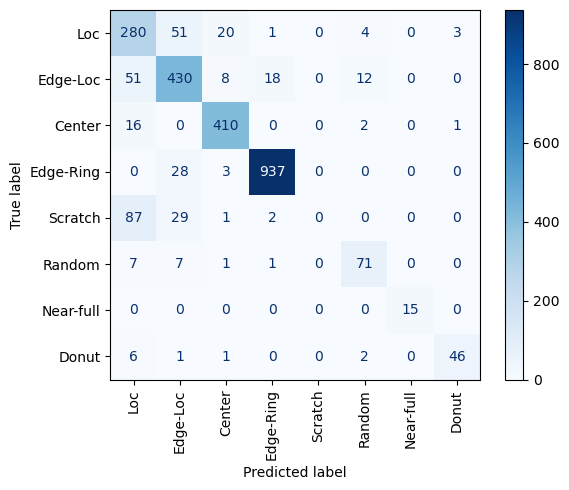

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 参考：https://qiita.com/wakame1367/items/5420ac91702edf993124
# 恐らく、こんな意味↓ ドキュメント見てもよくわからんかった。
# y_pred: 予測したfailureType, y_true: 正解のfailureType
labels = df['failureType'].unique()
cm = confusion_matrix(y_pred=user_result_df['failureType'], y_true=y_test_df['failureType'], labels=labels)
# display_labels: 集計して表示するラベル。
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)

cmp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')


In [7]:
#
# 誤分類したものを閲覧する。
#
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt

# 画像の表示関数
def image_show(target_df, y_test_df, x_test_df, user_result_df, x=0): 
    ori_image = x_test_df.waferMap[x]
    true_label = y_test_df.failureType[x]
    result_label = user_result_df.failureType[x]
    print('true label  :', true_label)
    print('result label:', result_label)
    plt.imshow(ori_image)
    plt.show()
    return x

# failureType 選択関数
def select_type(failureType='Loc'): 
    drop_indexes = []
    for index in range(len(user_result_df)):
        true_df = y_test_df.iloc[index]
        result_df = user_result_df.iloc[index]
        if true_df.failureType != failureType:
            drop_indexes.append(true_df.name)
            continue
        if true_df.failureType == result_df.failureType:
            drop_indexes.append(true_df.name)
    filterd_df = x_test_df.drop(index=drop_indexes)
    num_widget = widgets.IntSlider(
        value=0,
        min=0,
        max=len(filterd_df.waferMap) - 1
    )
    interact(image_show,
        x=num_widget,
        target_df=fixed(x_test_df.drop(index=drop_indexes).reset_index()),
        y_test_df=fixed(y_test_df.drop(index=drop_indexes).reset_index()),
        x_test_df=fixed(x_test_df.drop(index=drop_indexes).reset_index()),
        user_result_df=fixed(user_result_df.drop(index=drop_indexes).reset_index()),
    );

labels = y_test_df.failureType.unique() # ラベル取得
interact(select_type, failureType=labels); # failureType選択

interactive(children=(Dropdown(description='failureType', index=2, options=('Edge-Ring', 'Edge-Loc', 'Loc', 'R…